In [11]:
%load_ext autoreload
%autoreload 2

import lakeapi
import datetime as dt
from datetime import timedelta, datetime, date, time
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from polygon.rest import RESTClient
import time
import plotly.graph_objects as go 
import mplfinance as mpf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 100)

from polygon.rest import RESTClient
from test_momentum import test_correlation, block_permutation_test, get_block_size

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#download data 
key = open("api_key.txt").read()
client = RESTClient(key)
aggs = []
count = 0
for a in client.list_aggs("SPY", 1, "minute", "2025-01-01", "2025-04-01", limit = 50_000):
    aggs.append(a)

In [3]:
raw_df = pd.DataFrame(aggs)
raw_df['datetime_utc'] = pd.to_datetime(raw_df['timestamp'], unit = 'ms').dt.tz_localize('UTC')
#Remember to convert to ET time to match the NYSE 
raw_df['datetime_et'] = raw_df['datetime_utc'].dt.tz_convert('America/New_York')
raw_df = raw_df.set_index('datetime_et')
raw_df

,open,high,low,close,volume,vwap,timestamp,transactions,otc,datetime_utc
datetime_et,,,,,,,,,,
2025-01-02 04:00:00-05:00,588.22,589.0700,588.12,588.80,2374.0,588.6085,1735808400000,73,None,2025-01-02 09:00:00+00:00
2025-01-02 04:01:00-05:00,589.10,589.2500,589.10,589.16,976.0,589.1589,1735808460000,17,None,2025-01-02 09:01:00+00:00
2025-01-02 04:02:00-05:00,589.03,589.0300,588.85,588.93,1018.0,588.9268,1735808520000,36,None,2025-01-02 09:02:00+00:00
2025-01-02 04:03:00-05:00,588.90,588.9000,588.90,588.90,441.0,588.8906,1735808580000,20,None,2025-01-02 09:03:00+00:00
2025-01-02 04:04:00-05:00,589.00,589.0000,589.00,589.00,924.0,589.0021,1735808640000,26,None,2025-01-02 09:04:00+00:00
...,...,...,...,...,...,...,...,...,...,...
2025-04-01 19:54:00-04:00,561.90,562.0100,561.90,562.01,967.0,561.9857,1743551640000,19,None,2025-04-01 23:54:00+00:00
2025-04-01 19:55:00-04:00,561.90,561.9000,561.88,561.88,2185.0,561.8840,1743551700000,17,None,2025-04-01 23:55:00+00:00
2025-04-01 19:57:00-04:00,561.89,561.9494,561.89,561.92,2107.0,561.9270,1743551820000,16,None,2025-04-01 23:57:00+00:00


<Axes: xlabel='datetime_et'>

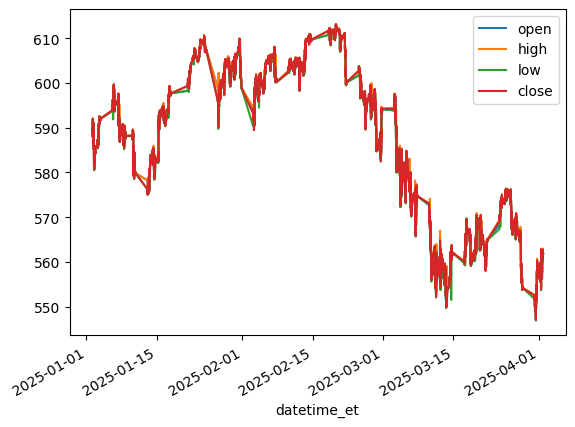

In [121]:
raw_df[['open', 'high', 'low', 'close']].plot()

In [123]:
raw_df.index.hour.unique()

Index([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int32', name='datetime_et')

In [126]:
raw_df.index.day_of_week.unique().sort_values()

Index([0, 1, 2, 3, 4], dtype='int32', name='datetime_et')

In [4]:
#align with trading hours
df = raw_df.between_time('09:30', '16:00')[['open', 'high', 'low', 'close']]

<Axes: xlabel='datetime_et'>

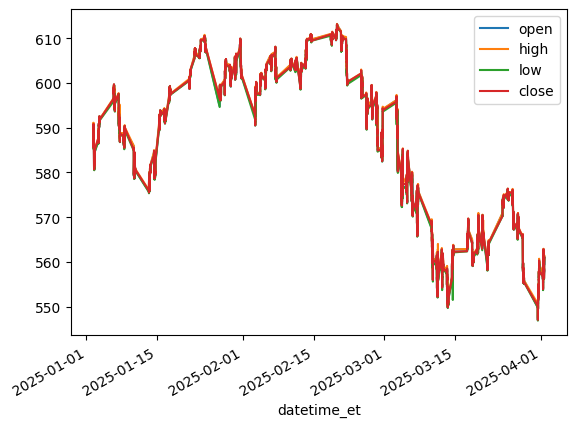

In [128]:
df.plot()

In [166]:
#Donchian Channel/Breakout Strategy - Test for profitability of trading signal on intraday data 
#Challenge - adapt donchian to fit intraday data 
#core challenge - liquidate at end of day
from donchian import donchian

In [8]:
TRADING_DAYS_PER_YEAR = 252
N_BARS_PER_YEAR = 252*7.5*60*60 #252 days, 7.5 hours per day, 60 minutes per hour, 60 seconds per minute 

In [130]:
results = intraday_donchian(ohlc = df, lookback = timedelta(seconds=20), n_bars_in_year = N_BARS_PER_YEAR)

In [131]:
results['metrics']

{'profit_factor': np.float64(0.9995297450854859),
 'sharpe_ratio': np.float64(-0.4505387402353905),
 'sortino_ratio': np.float64(-1.2961771570794702)}

<Axes: xlabel='datetime_et'>

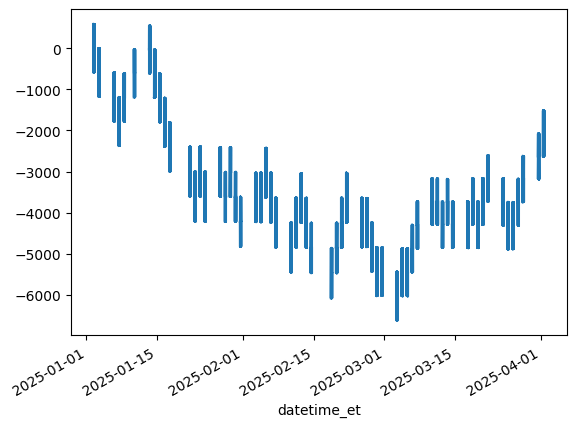

In [132]:
results['summary_df']['pnl'].cumsum().plot()

In [14]:
from donchian import donchian, plot_donchian

In [9]:
#crude optimisation 
results_by_lookback = {}
lookback_by_label = {
    '20s': timedelta(seconds=20), 
    '1min': timedelta(minutes=1), 
    '10min': timedelta(minutes=10), 
    '1h': timedelta(hours=1), 
    '2h': timedelta(hours=2), 
    '4h': timedelta(hours=4)
}

for label, lookback in lookback_by_label.items():
    results = donchian(df, lookback, N_BARS_PER_YEAR, intraday=True)
    results_by_lookback[label] = results 

#return entry with max sharpe ratio  
best_lookback = max({label: results['metrics']['sharpe_ratio']for label, results in results_by_lookback.items()}.items(), key = lambda item: item[1])
best_lookback

('20s', np.float64(1.5403874178324022e-15))

In [10]:
{label: results['metrics']['sharpe_ratio']for label, results in results_by_lookback.items()}

{'20s': np.float64(1.5403874178324022e-15),
 '1min': np.float64(1.5403874178324022e-15),
 '10min': np.float64(-1.091994983830376e-15),
 '1h': np.float64(-1.4141839274950147e-15),
 '2h': np.float64(1.2300910566016701e-16),
 '4h': np.float64(-8.551448685247259e-16)}

All strategies seem to have negative returns on average - why? 

ValueError: x and y must have same first dimension, but have shapes (0,) and (23851,)

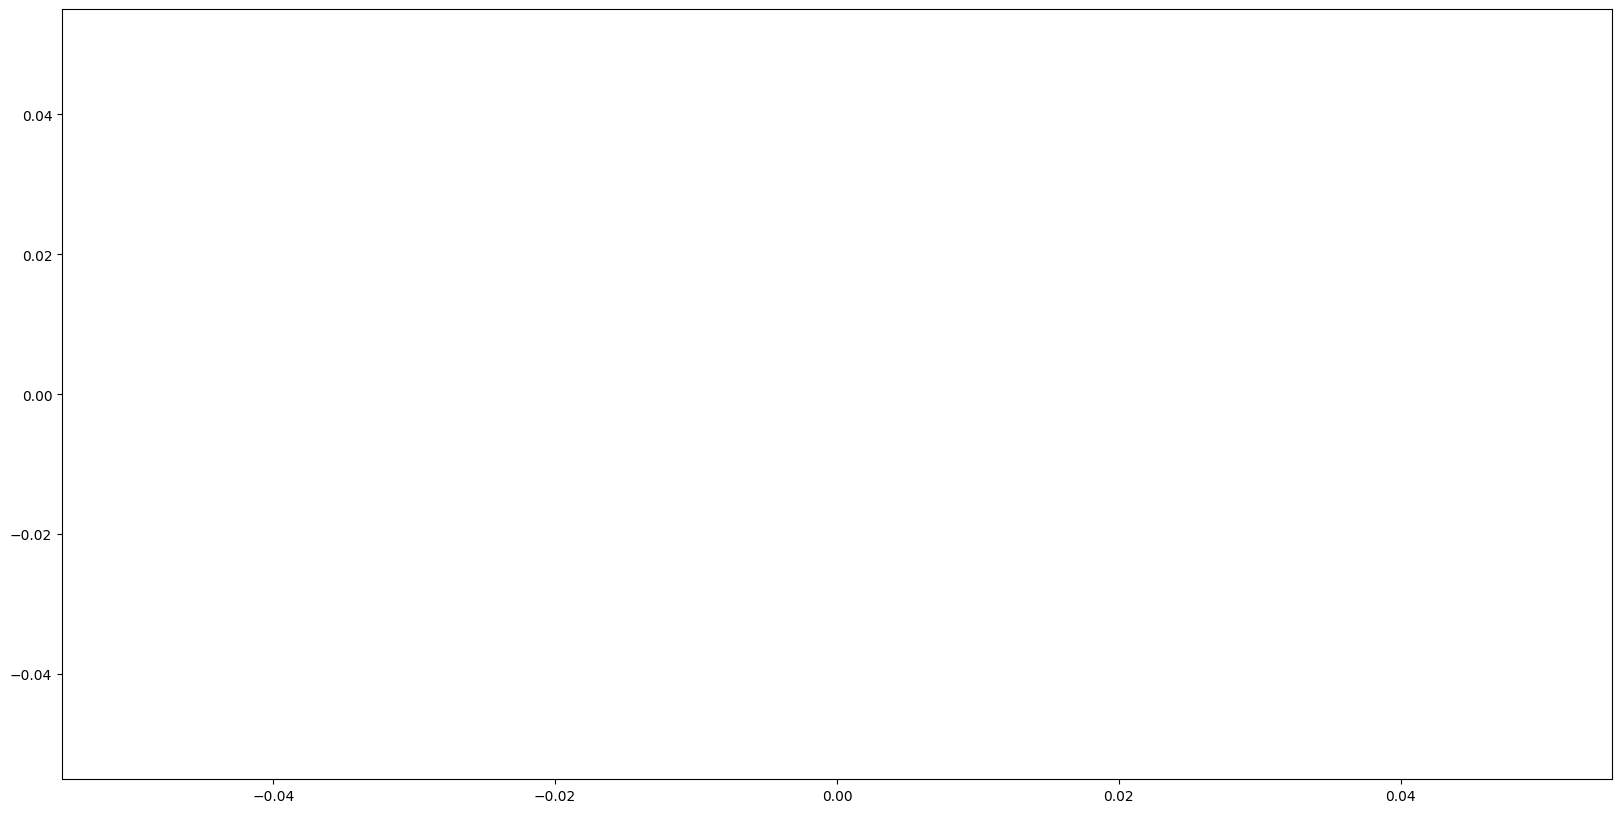

In [23]:
#Plot 
plot_donchian(df, results_by_lookback['20s']['summary_df']['Signal'], lookback = lookback_by_label['20s'], figsize = (20, 10), sample_date = '2025-02-01')

In [135]:
#winner - positive profit factor, and negative sharpe ratio - why? Why is this strategy losing money/not profitable? 

#possibility 1 - are losses happening from FORCED liquidation at end of the day? - Doesn't look like it 
winner = results_by_lookback['20s']
summary_df = winner['summary_df']
summary_df.groupby(summary_df.index.hour)['pnl'].mean()

datetime_et
9     -0.715501
10     0.218319
11    -2.354762
12     2.852493
13    -3.172799
14     0.309828
15     1.319379
16    36.422623
Name: pnl, dtype: float64

<Axes: xlabel='datetime_et'>

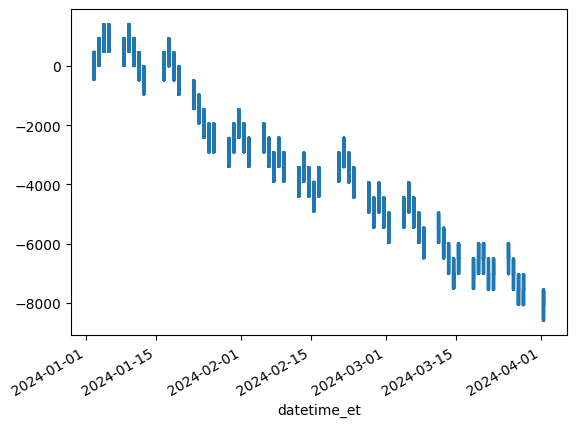

In [43]:
#visualisation
#plot 1 - equity curve 
summary_df['pnl'].cumsum().plot()

In [91]:
#Visualise signal frequency - when do the long/short occur? 
signal = summary_df['Signal']
#summarise - on average, how many long per day? how many short positions per day? 
print(f"Total signals: {(signal != 0).sum()}")
print(f"Long signals: {(signal == 1).sum()}")
print(f"Short signals: {(signal == -1).sum()}")
print(f"Signal changes: {signal.diff().abs().sum()}")

#averge number per day 
signal.groupby(signal.index.date).value_counts().groupby(level='Signal').mean()

Total signals: 11619
Long signals: 6183
Short signals: 5436
Signal changes: 15542.0


Signal
-1     87.677419
 0    203.596774
 1     99.725806
Name: count, dtype: float64

Breakouts above: 6188
Breakouts below: 5446


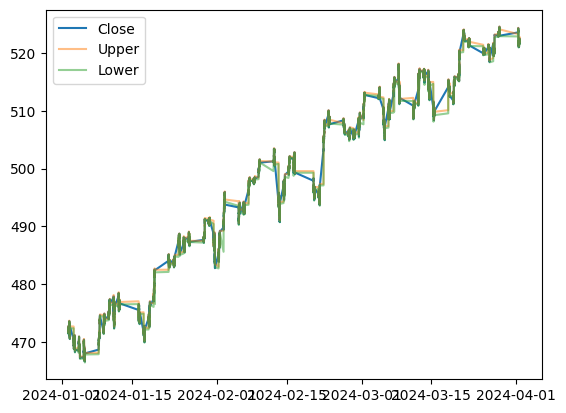

In [92]:
#do the bands every trigger? clearly they do 
lookback = timedelta(seconds = 20)
upper = df['high'].rolling(lookback).max().shift(1)
lower = df['low'].rolling(lookback).min().shift(1)

print(f"Breakouts above: {(df['close'] > upper).sum()}")
print(f"Breakouts below: {(df['close'] < lower).sum()}")

# Plot bands
plt.plot(df['close'], label='Close')
plt.plot(upper, label='Upper', alpha=0.5)
plt.plot(lower, label='Lower', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
#Look at/inspect one day in detail 
day = '2024-01-02'
day_data = df.loc[day]
day_signal = summary_df.loc[day]['Signal']
day_pnl = summary_df.loc[day]['pnl']

day_data[['close']].join(day_signal).join(day_pnl)

,close,Signal,pnl
datetime_et,,,
2024-01-02 09:30:00-05:00,472.5300,0,NaN
2024-01-02 09:31:00-05:00,472.6812,1,472.6812
2024-01-02 09:32:00-05:00,472.7800,1,0.0988
2024-01-02 09:33:00-05:00,472.6900,0,-472.7800
2024-01-02 09:34:00-05:00,472.6700,0,0.0000
...,...,...,...
2024-01-02 15:56:00-05:00,472.2300,1,472.2300
2024-01-02 15:57:00-05:00,472.4200,1,0.1900
2024-01-02 15:58:00-05:00,472.5898,1,0.1698


In [ ]:
#look for bugs 
#look-ahead bias 
#return calculation
#signal logic 

In [ ]:
#win rate 
winner['metrics']['profit_factor']

#results are consistent - the strategy loses money overall 

np.float64(0.9979069179059235)

In [ ]:
#check the market regime - does a strategy like this work/not work? Consider analysis of statistical signals 

In [ ]:
#Comparison - BTC Donchian seems to make money - why? Why are these two different? What is different about them? Get Binance OHLC data for same 3 months around this period and analyse WHY 

In [ ]:
#confused - aren't we just giving up profit here since we are waiting until the reversal? like that just does not make sense to me

In [2]:
#Binance - BTC data - just use top-level bid/ask data for brevty 
raw_df=pd.read_parquet('../pairs_trading_cryptocurrency/data/level1crypto_raw_origin_times_resampled.parquet')

In [3]:
train_df = raw_df[raw_df.symbol=='BTC-USDT'][['bid_0_price', 'ask_0_price', 'bid_0_size', 'ask_0_size']].rename(columns={
    'bid_0_price': 'bid', 
    'ask_0_price': 'ask', 
    'bid_0_size': 'bid_size', 
    'ask_0_size': 'ask_size'
})
train_df['mid'] = train_df[['bid', 'ask']].mean(axis=1)

In [4]:
#temporary - just put in the variables 
train_df['high'] = train_df['mid']
train_df['low'] = train_df['mid']
train_df['close'] = train_df['mid']

<Axes: xlabel='origin_time'>

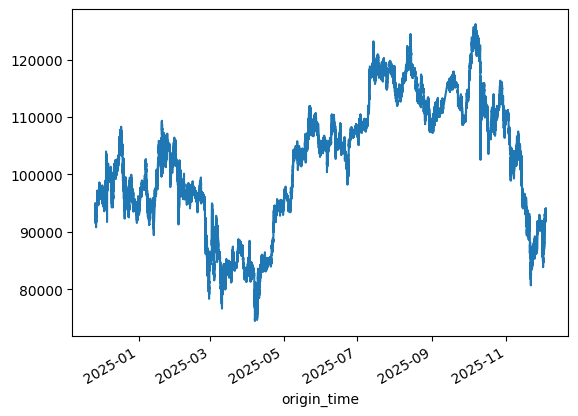

In [92]:
train_df['mid'].plot()

In [93]:
train_df.isna().sum()

bid         0
ask         0
bid_size    0
ask_size    0
mid         0
high        0
low         0
close       0
dtype: int64

In [94]:
train_df.asfreq('1h')

,bid,ask,bid_size,ask_size,mid,high,low,close
origin_time,,,,,,,,
2024-11-26 00:00:00,92935.90,92935.91,2.55032,0.36348,92935.905,92935.905,92935.905,92935.905
2024-11-26 01:00:00,93826.36,93826.37,0.60384,5.48286,93826.365,93826.365,93826.365,93826.365
2024-11-26 02:00:00,94797.52,94797.53,0.00092,4.77405,94797.525,94797.525,94797.525,94797.525
2024-11-26 03:00:00,94571.81,94571.82,0.90593,9.09417,94571.815,94571.815,94571.815,94571.815
2024-11-26 04:00:00,94475.99,94476.00,6.60103,0.00738,94475.995,94475.995,94475.995,94475.995
...,...,...,...,...,...,...,...,...
2025-12-03 19:00:00,92605.40,92605.41,3.25387,2.74422,92605.405,92605.405,92605.405,92605.405
2025-12-03 20:00:00,93066.01,93066.02,10.05834,0.01704,93066.015,93066.015,93066.015,93066.015
2025-12-03 21:00:00,92970.12,92970.13,0.17805,1.37787,92970.125,92970.125,92970.125,92970.125


In [54]:
results_by_lookback = {}
lookback_by_label = {
    # '1min': timedelta(minutes=1), 
    # '10min': timedelta(minutes=10), 
    '1h': timedelta(hours=1), 
    '2h': timedelta(hours=2), 
    '4h': timedelta(hours=4), 
    '12h': timedelta(hours=12), 
    '1d': timedelta(days=1), 
    '7d': timedelta(days=7), 
    '1month': timedelta(days=28), 
    '2month': timedelta(days=56), 
    '3month': timedelta(days=86), 
    '4month': timedelta(days=112), 
}

for label, lookback in lookback_by_label.items():
    results = donchian(train_df.asfreq('1h'), lookback, N_BARS_PER_YEAR, intraday=False)
    results_by_lookback[label] = results 

#return entry with max sharpe ratio  
best_lookback = max({label: results['metrics']['sharpe_ratio']for label, results in results_by_lookback.items()}.items(), key = lambda item: item[1])

In [55]:
{label: results['metrics']['profit_factor']for label, results in results_by_lookback.items()}

{'1h': 1.0102486301400184,
 '2h': 1.0157507642447319,
 '4h': 1.0139173663755747,
 '12h': 1.0012255295377646,
 '1d': 0.9928802309485109,
 '7d': 0.9976216543158027,
 '1month': 0.9260528359028838,
 '2month': 0.9194936533872812,
 '3month': 0.9080190086629112,
 '4month': 0.9100968729406135}

Interesting... why are none of these strategies making money? Seems to be a very poor strategy.

In [ ]:
#Visualisation - Be able to answer WHY/why not these strategies are making money - leave for today, and then answer another day 

In [ ]:
#Momentum vs. order book data - how can we use?
#Part 1 - Order flow/book strategies for high frequency momentum trading 

In [83]:
train_df.iloc[-1]

bid         93429.95000
ask         93429.96000
bid_size        1.54433
ask_size        3.67268
mid         93429.95500
high        93429.95500
low         93429.95500
close       93429.95500
Name: 2025-12-03 23:59:50, dtype: float64

In [5]:
train_df = train_df.loc['2025-09-01':'2025-12-03']

<Axes: xlabel='origin_time'>

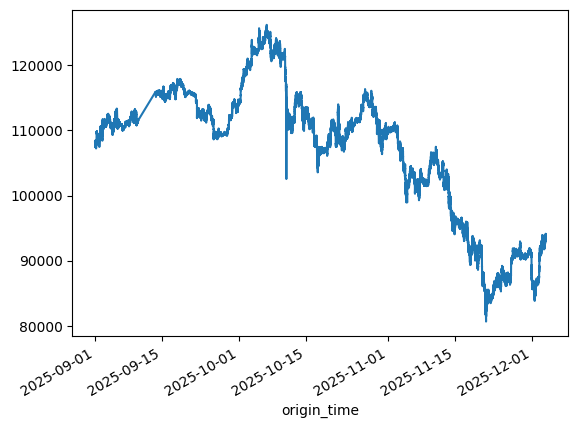

In [105]:
train_df['mid'].plot()

<Axes: xlabel='origin_time'>

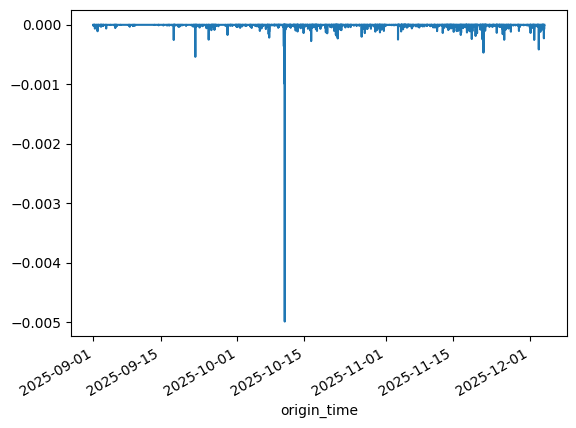

In [106]:
((train_df['bid'] - train_df['ask'])/train_df['mid']).plot()

In [107]:
#Test for prescence of momentum
correlation_df = test_correlation(train_df['mid'], lookback = np.arange(1, 30), holding = np.arange(1,30)).sort_values(by = ['correlation'], ascending=False)

In [116]:
correlation_df[correlation_df['lookback']==1]

,lookback,holding,correlation
1,1,2,0.029228
0,1,1,0.027663
4,1,5,0.015667
2,1,3,0.014821
5,1,6,0.010161
6,1,7,0.007688
24,1,25,0.006385
3,1,4,0.005606
23,1,24,0.005436
22,1,23,0.005346


In [37]:
#Test for order book momentum 
#Calculate correlation between order book imbalance and forward returns 
train_df['order_book_imbalance'] = (train_df['bid_size'] - train_df['ask_size']) / (train_df['bid_size'] + train_df['ask_size'])
for horizon in [1, 3, 6, 18, 30, 60, 120, 300]:
    train_df[f'fwd_ret_{horizon}'] = train_df['mid'].pct_change(horizon).shift(-horizon) #Shift it backwards so the indexes align 
train_df[['order_book_imbalance', 'fwd_ret_1', 'fwd_ret_3', 'fwd_ret_6', 'fwd_ret_18', 'fwd_ret_30', 'fwd_ret_60', 'fwd_ret_120', 'fwd_return_300']].corr()['order_book_imbalance']

KeyError: "['fwd_return_300'] not in index"

In [15]:
get_block_size(train_df['fwd_ret_18'])

ACF insignificant at lag 42
Block size: 42


42

In [10]:
#Are these statistically significant? Idea - if this historical data was pure NOISE, then what is the probability of generating this result? 
#block permutation testing 

#decide on a bunch of blocks - quickest
block_permutation_test(x = train_df['order_book_imbalance'], y = train_df['fwd_ret_1'], block_size = 30)

Running 10000 permutations...


100%|██████████| 10000/10000 [00:40<00:00, 245.55it/s]


{'observed_correlation': np.float64(0.18266861072874407),
 'p_value': np.float64(0.0),
 'permutation_distribution': array([ 0.00025358,  0.00037603, -0.00081194, ...,  0.00045998,
         0.00256947, -0.00058538], shape=(10000,)),
 'permutation_mean': np.float64(2.4808113128950655e-05),
 'permutation_std': np.float64(0.0011382135835996709)}

In [16]:
block_permutation_test(x = train_df['order_book_imbalance'], y = train_df['fwd_ret_3'], block_size = 30)

Running 10000 permutations...


100%|██████████| 10000/10000 [00:42<00:00, 234.06it/s]


{'observed_correlation': np.float64(0.12301901623267163),
 'p_value': np.float64(0.0),
 'permutation_distribution': array([ 0.00353526, -0.00141587,  0.00149946, ...,  0.00102403,
        -0.0009628 ,  0.00072657], shape=(10000,)),
 'permutation_mean': np.float64(1.6499367736075602e-05),
 'permutation_std': np.float64(0.0013798969880867934)}

In [17]:
block_permutation_test(x = train_df['order_book_imbalance'], y = train_df['fwd_ret_18'], block_size = 30)

Running 10000 permutations...


100%|██████████| 10000/10000 [00:39<00:00, 250.30it/s]


{'observed_correlation': np.float64(0.05134472493506208),
 'p_value': np.float64(0.0),
 'permutation_distribution': array([-0.00323435, -0.00229893, -0.0004117 , ..., -0.00103835,
        -0.00024499, -0.0028947 ], shape=(10000,)),
 'permutation_mean': np.float64(5.548151900172549e-07),
 'permutation_std': np.float64(0.0018105855657909182)}

In [ ]:
#Question - Is the data actally stable across the periods? 
for month in [9, 10, 11, 12]:
    temp_df = train_df.loc[train_df.index.month==montha]
    temp_df[['order_book_imbalance', 'fwd_ret_1', 'fwd_ret_3', 'fwd_ret_6', 'fwd_ret_18']].corr()['order_book_imbalance']

order_book_imbalance    1.000000
fwd_ret_1               0.223853
fwd_ret_3               0.170885
fwd_ret_6               0.136004
fwd_ret_18              0.080476
Name: order_book_imbalance, dtype: float64

order_book_imbalance    1.000000
fwd_ret_1               0.167835
fwd_ret_3               0.116069
fwd_ret_6               0.086095
fwd_ret_18              0.047423
Name: order_book_imbalance, dtype: float64

order_book_imbalance    1.000000
fwd_ret_1               0.186993
fwd_ret_3               0.114923
fwd_ret_6               0.079112
fwd_ret_18              0.045090
Name: order_book_imbalance, dtype: float64

order_book_imbalance    1.000000
fwd_ret_1               0.188119
fwd_ret_3               0.105389
fwd_ret_6               0.077211
fwd_ret_18              0.037605
Name: order_book_imbalance, dtype: float64

In [ ]:
#Biggest blocker - are there any disqualifiers to trading on order book imbalances? For example, where I would literally just LOSE money e.g. based on fees
train_df['order_book_quintile'] = pd.qcut(train_df['order_book_imbalance'], q = [0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = [5, 4, 3, 2, 1])

In [32]:
train_df[f"entry_fees"] = train_df['mid']*0.001
for horizon in [1, 3, 6, 18, 30, 60]:
    train_df[f'round_trip_fees_{horizon}'] = ((train_df['mid']*0.001).shift(-horizon) + train_df[f'entry_fees'])/train_df['mid']

In [33]:
train_df.columns

Index(['bid', 'ask', 'bid_size', 'ask_size', 'mid', 'high', 'low', 'close',
       'order_book_imbalance', 'fwd_ret_1', 'fwd_ret_3', 'fwd_ret_6',
       'fwd_ret_18', 'fwd_ret_30', 'fwd_ret_60', 'order_book_quintile',
       'entry_fees', 'round_trip_fees', 'round_trip_fees_1',
       'round_trip_fees_3', 'round_trip_fees_6', 'round_trip_fees_18',
       'round_trip_fees_30', 'round_trip_fees_60'],
      dtype='object')

In [35]:
train_df.groupby('order_book_quintile').apply(lambda x: (x['fwd_ret_18'] - x['round_trip_fees_18']).mean())

/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_63572/2518798795.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby('order_book_quintile').apply(lambda x: (x['fwd_ret_18'] - x['round_trip_fees_18']).mean())
/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_63572/2518798795.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df.groupby('order_book_quintile').apply(lambda x: (x['fwd_ret_18'] - x['round_trip_fees_18']).mean())


order_book_quintile
5   -0.002081
4   -0.002040
3   -0.002004
2   -0.001963
1   -0.001925
dtype: float64

Conclusion - signal is present, but not profitable enough to beat round trip fees. 

In [ ]:
#Round-about profit guestimation - how? 

In [ ]:
#Universe expansion - how about in the larger crypto universe? 